# Week of 2025.07.30

## Goal of this week:
- [ ] Create clean visulizations that show the current state of the infrasound work.
- [ ] Coordinate meeting with Fred + Mario + Eric to discuss the current state of things and figure out what needs to further be worked on.


## Things to change
- Plot mach numbers 
- Color bar of atmosphere + plot heat 
- Add atmosphere temperature plot.
- Reduce stem to maybe 10 m
- time series of flank of volcano. 

In [1]:
%load_ext autoreload
%autoreload 2

from helper_code.slip_imports import *
from helper_code.helper_functions import get_local_solver_from_index_func, get_quantities_at_conduit_exit, get_quantities_at_all_space
from helper_code.animate import animate_conduit_pressure, animate_melt_atmosphere_combination
from helper_code.analytical_solution import get_lumped_solution

import helper_code.infrasound as infrasound
from matplotlib.animation import FuncAnimation

import matplotlib.pyplot as plt 
plt.rcParams['animation.ffmpeg_path'] = '/opt/homebrew/bin/ffmpeg'

folder_name = "simple_conduit"

ITERS = 50
D_ITERS = 1
END_TIME = 10
C0 = 320 # m/s at 5000m

## 1.0 Eruption paired with **1D** atmosphere

In [2]:
folder_name = "2025_07_23_eruption_1d_atmosphere_sim"
melt_file_name = "tungurahua_atm_1m"
atmosphere_file_name = "vertical_atmosphere_01_atm1"
melt_solver_func = get_local_solver_from_index_func(folder_name, melt_file_name)
atmosphere_solver_func = get_local_solver_from_index_func(folder_name, atmosphere_file_name)

iters = 100

ani = animate_melt_atmosphere_combination(
    melt_solver_func,
    atmosphere_solver_func,
    iterations=100,
    d_iterations=5,
    y_min=-1000,
    y_max=1000,
    max_pressure=0.13,
    min_pressure=0.07,
    max_velocity=100,
    min_velocity=0,
    max_density=3e3,
    min_density=0,
    max_slip=150,
    min_slip=0,
)

HTML(ani.to_html5_video())

## 2.0 Eruption paired with **2D** atmosphere

### 2.1 Melt

In [3]:
file_name = "tungurahua_no_atm_v0"
folder_name = "2025_07_21_eruption_sim"
iters = 100
solver_func = get_local_solver_from_index_func(folder_name, file_name)
ani = animate_conduit_pressure(
    solver_func,
    iterations=iters,
    d_iterations=4,
    viscosity_index=1,
    wall_friction_index=5,
    max_velocity=20,
    max_slip=60,
    max_tau=1.5,
    max_pressure=50,
    max_speed_of_sound=2000,
    max_water=1,
    max_density=5e3,
    max_fragmentation=5000,
    max_crystal=100,
    max_viscosity=0.1,
)

HTML(ani.to_html5_video())

### 2.2 Atmosphere
- Time elapsed for me to run this simulation locally: 10hr?

In [19]:
from helper_code.atmosphere_animate import atmosphere_2d_animate

folder_name = "2025_07_21_eruption_sim"
file_name = "test_infrasound_v1_atm1"
iterations = 3

ani = atmosphere_2d_animate(
    iterations=iterations,
    d_iter=1,
    folder=folder_name,
    file_name=file_name
)

HTML(ani.to_html5_video())

### 2.1 Time Series Pressure Data


In [27]:
import matplotlib.tri as tri
from helper_code.infrasound import *

folder_name = "2025_07_21_eruption_sim"
file_name = "test_infrasound_v1_atm1"
solver_func = get_local_solver_from_index_func(folder_name, file_name)
iterations = 3

solver_0 = solver_func(0)

triangulation = tri.Triangulation(solver_0.mesh.node_coords[...,0],
                  solver_0.mesh.node_coords[...,1], 
                  triangles=solver_0.mesh.elem_to_node_IDs)

trifinder = triangulation.get_trifinder()

p_20 = infrasound.get_p_series(20, 0, solver_func, trifinder, iterations=iterations, p0=1e5)
p_50 = infrasound.get_p_series(50, 0, solver_func, trifinder, iterations=iterations, p0=1e5)
p_80 = infrasound.get_p_series(80, 0, solver_func, trifinder, iterations=iterations, p0=1e5)

Element ID for point (20, 0): 5085
Element ID for point (50, 0): 6102
Element ID for point (80, 0): 6478


/var/folders/f7/g7y34v812n5_58yvtkt3mrw40000gn/T/ipykernel_98401/568797692.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')


Text(0.5, 0.01, 'time (s)')

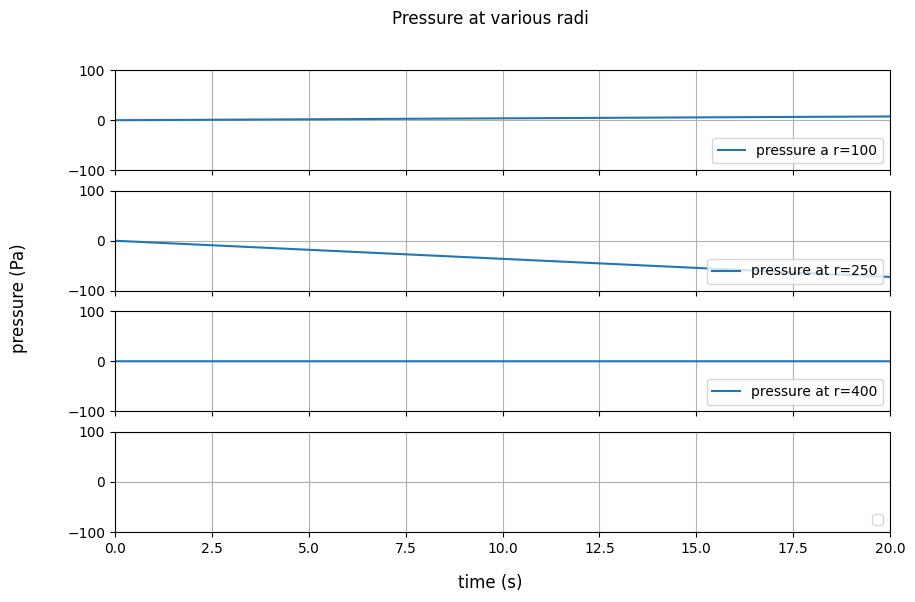

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 6), sharex=True)
t = np.linspace(0, 0.3, len(p_20))
C0 = 320

axes[0].plot(t, p_20, label="pressure a r=100")
axes[1].plot(t, p_50, label="pressure at r=250")
axes[2].plot(t, p_80, label="pressure at r=400")


for i, ax in enumerate(axes):
    ax.legend(loc='lower right')
    ax.grid(True)
    ax.set_ylim(-100, 100)  
    ax.set_xlim(0, 20)

fig.suptitle("Pressure at various radi")
fig.supylabel("pressure (Pa)")
fig.supxlabel("time (s)")

## A1. Review 2D Mesh

- The finest triangle mesh is of length 0.3m. That size expands to 3m per side outside of the vent tube. 

/Users/paxton/git/quail_volcano/src

Points: (4897, 3)
Cells: dict_keys(['line', 'triangle'])
Cell Sets: {}


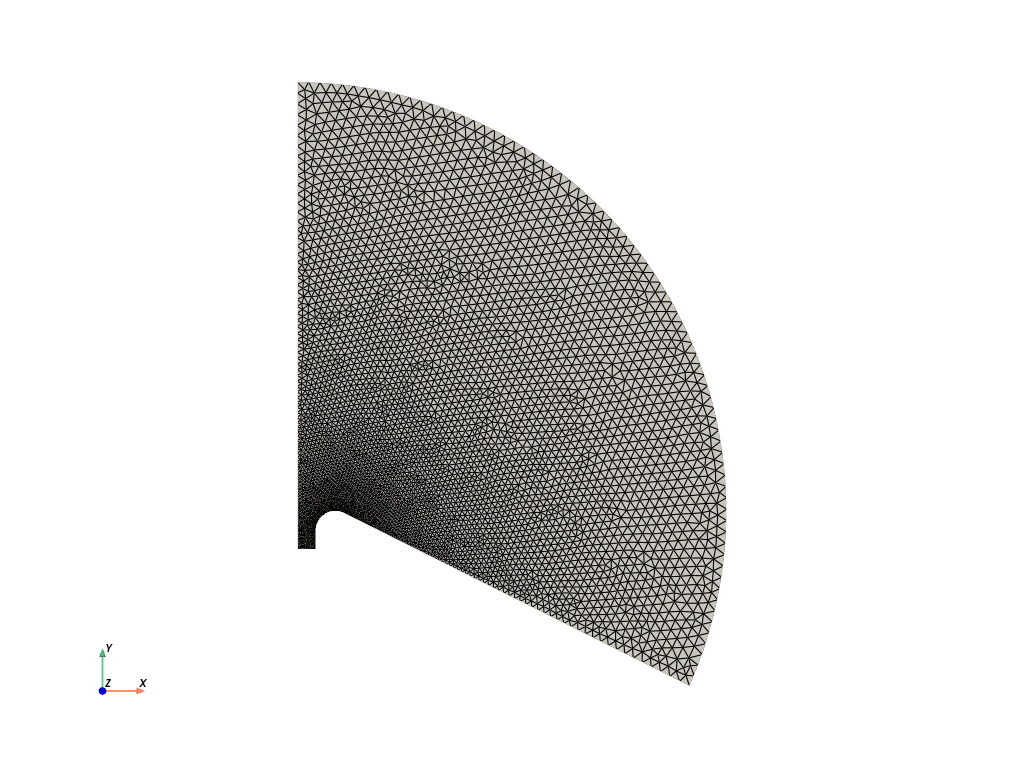

In [6]:
import meshio
import pyvista as pv
import os

print(os.getcwd())

mesh = meshio.read(f"{BASE_PATH}/quail_volcano/scenarios/meshes/tungurahuaA1.msh")

# Clear cell sets to avoid the error
mesh.cell_sets.clear()

# Print mesh details
print("Points:", mesh.points.shape)
print("Cells:", mesh.cells_dict.keys())
#for cell_type, cell_data in mesh.cells_dict.items():
    #print(f"Cell type {cell_type}: {cell_data.shape}")
print("Cell Sets:", mesh.cell_sets)
#print("Cell Data:", mesh.cell_data)

pv.set_jupyter_backend('static')

# Convert to pyvista mesh
pv_mesh = pv.from_meshio(mesh)

# Create a plotter and visualize
plotter = pv.Plotter()

plotter.add_mesh(pv_mesh, show_edges=True, color="white")
plotter.set_scale(xscale=1.0, yscale=1.0, zscale=1.0)
plotter.camera.roll += 80

plotter.view_xy()  # For 2D meshes; use view_isometric() for 3D
plotter.show_axes()
plotter.show()